## Import dependent libraries

In [1]:
from pandas import read_csv
from matplotlib import pyplot
import math
from numpy import concatenate, array, asarray
from pandas import DataFrame
from pandas import concat
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model, model_from_json
from keras.layers import Input
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from sklearn.externals import joblib
import tensorflow as tf
from keras.utils import plot_model
import keras.backend as K
import random
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import time
import os
import sys
from TimeSeriesModel import TimeSeriesModel

Using TensorFlow backend.


## Parameters

In [2]:
# specify the number of lag hours
n_hours = 64
n_features = 2
n_train_hours = 1000
n_divisions = 4
batch_size = n_hours
epochs = 20

## Load dataset

In [3]:
dataset = read_csv('music_data.csv', header=0)
values = dataset.values
values = values.astype('float32')

## Specify columns to plot

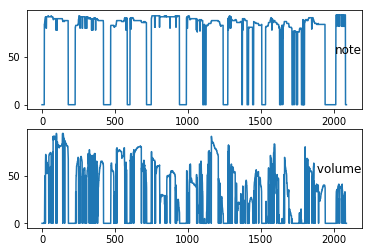

In [4]:
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1


pyplot.show()

## Convert series to supervised learning

In [5]:
dataset = read_csv('music_data.csv', header=1)
values = dataset.values
values = values.astype('float32')

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    start = time.time()
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    end = time.time()
    print(end - start)
    return agg

## Scale Data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
print(scaled[20:21])


[[ 0.95744675  0.43617019]]


In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

0.03583502769470215


In [9]:
values = reframed.values
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features

In [10]:
train_X = train[:, :n_obs]
# print(train_X)

train_y_notes = train[:, -n_features]
train_y_volume = train[:, -n_features -1]

test_X = test[:, :n_obs]
# print(test_X)
test_y_notes = test[:, -n_features]
test_y_volume = test[:, -n_features -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# print(train_X[0:10])

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y_notes.shape, test_X.shape, test_y_notes.shape)
print(test_X[0:1].shape)


(1000, 64, 2) (1000,) (1024, 64, 2) (1024,)
(1, 64, 2)


In [11]:
visible = Input(name='input', shape=(n_hours, n_features))
ts_model = TimeSeriesModel(visible, n_hours, n_features, n_divisions)

In [12]:
# concat = keras.layers.concatenate([output0, output1, output2, output3])
# print(concat)
# tdd = keras.layers.TimeDistributed(Dense(branch_input_size))(concat)
# hidden_Z = LSTM(branch_input_size)(tdd)
model = ts_model.model()

output_notes = Dense(1, activation='sigmoid', name='output_notes')(model)
output_volume = Dense(1, activation='sigmoid', name='output_volume')(model)
# output_length = Dense(1, activation='sigmoid', name='output_length')(hidden_Z)

model = Model(inputs=[visible], outputs=[
                                         output_notes, 
                                         output_volume, 
#                                          output_length
                                        ])

Tensor("input:0", shape=(?, 64, 2), dtype=float32)
num 0
0 16
Tensor("lstm_2/transpose_1:0", shape=(?, ?, 4), dtype=float32)
num 1
16 32
Tensor("lstm_4/transpose_1:0", shape=(?, ?, 4), dtype=float32)
num 2
32 48
Tensor("lstm_6/transpose_1:0", shape=(?, ?, 4), dtype=float32)
num 3
48 64
Tensor("lstm_8/transpose_1:0", shape=(?, ?, 4), dtype=float32)


In [13]:
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer=optimizer)
# model.summary()

In [14]:
# plot_model(model, to_file='model.png')

In [15]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
test_data = [[0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [0, 0],
             [84, 1],
             [84, 0],
             [86, 20],
             [89, 48],
             [89, 0],
             [90, 41],
             [91, 50],
             [91, 0],
             [92, 65],
             [92, 72],
             [92, 72],
             [92, 69],
             [80, 69],
             [80, 66],
             [80, 66],
             [92, 60],
             [92, 64],
             [92, 52],
             [92, 52],
             [92, 56],
             [92, 59],
             [92, 59],
             [92, 59],
             [92, 60],
             [92, 60],
             [93, 61],
             [93, 57],
             [93, 57],
             [93, 57],
             [92, 59],
             [92, 0],
             [92, 70],
             [92, 71],
             [92, 72],
             [92, 72],
             [92, 72],
             [92, 73],
             [92, 73],
             [92, 73],
             [92, 73],
             [92, 73],
             [92, 74],
             [92, 74],
             [92, 74],
             [92, 74],
             [92, 73],
             [93, 73],
             [93, 0],
             [93, 58]]


In [17]:
def process_data(testx):
    testx = DataFrame(data = testx)
    testx = testx.values
    testx = testx.astype('float32')
    testx = scaler.transform(testx)
    return(testx)

In [18]:
class File_Writer:
    def __init__(self, filename=''):
        self.default_filename = 'output.csv'
        self.file_name = self.get_path(filename)
        self.file = open(self.file_name, "w")

        self.prepare_file()

    def get_path(self, filename):
        current_path = os.path.dirname(os.path.abspath(__file__))
        if filename == '':
            filename = self.default_filename

        path = current_path + '/data/' + filename

        print('Data will be written to:', path)
        return path

    def prepare_file(self):
        self.file.write('note, volume, length\n')

    def write_to_csv(self, predicted_values):
        note = predicted_values['note']
        length = predicted_values['length']
        volume = predicted_values['volume']

        result = '{}, {}\n'.format(note, volume)
        self.file.write(result)


In [19]:
array_to_play = test_data[:]

In [20]:
def on_epoch_end(epoch, logs):
    start = time.time()
    print('----- Generating sound after: %d' % epoch)
    for i in range(64):
        data = process_data(test_data)
        data = data.reshape(1,64,2)
        prediction = model.predict(data)
        prediction = asarray(prediction).ravel().reshape(-1,2)
        prediction = scaler.inverse_transform(prediction)
        prediction = prediction.astype('int')
        prediction = prediction[0].tolist()
        test_data.append(prediction)
        test_data.pop(0)
        array_to_play.append(prediction)
    print('array_to_play:', array_to_play)

#     print(test_data)
#     print("PREDICTION:")
#     print(prediction[0])
#     print("Note:", prediction[0][0], "Volume:", prediction[0][1])
    end = time.time()
    print('time:', end - start)
    
play_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [21]:
history = model.fit(
            {'input': train_X},
            {
                'output_notes': train_y_notes, 
                'output_volume': train_y_volume, 
            },
            validation_data=({'input': test_X},
                             {
                                 'output_notes': test_y_notes, 
                                 'output_volume': test_y_volume, 
                             }), 
            verbose=1,
            shuffle=False,
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[play_callback]
)

Train on 1000 samples, validate on 1024 samples
Epoch 1/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.7330 - output_notes_loss: 0.4564 - output_volume_loss: 0.2766----- Generating sound after: 0
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48], [48, 48], [48, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 48], [47, 

1000/1000 [==============================] - 7s - loss: 0.6077 - output_notes_loss: 0.3532 - output_volume_loss: 0.2546 - val_loss: 0.6757 - val_output_notes_loss: 0.3832 - val_output_volume_loss: 0.2924
Epoch 5/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.5567 - output_notes_loss: 0.3030 - output_volume_loss: 0.2537----- Generating sound after: 4
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48],

1000/1000 [==============================] - 7s - loss: 0.4879 - output_notes_loss: 0.2416 - output_volume_loss: 0.2463 - val_loss: 0.6201 - val_output_notes_loss: 0.3305 - val_output_volume_loss: 0.2896
Epoch 7/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.4521 - output_notes_loss: 0.2051 - output_volume_loss: 0.2470----- Generating sound after: 6
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48],

1000/1000 [==============================] - 7s - loss: 0.4155 - output_notes_loss: 0.1760 - output_volume_loss: 0.2395 - val_loss: 0.5683 - val_output_notes_loss: 0.2833 - val_output_volume_loss: 0.2849
Epoch 9/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.4132 - output_notes_loss: 0.1740 - output_volume_loss: 0.2391----- Generating sound after: 8
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48],

1000/1000 [==============================] - 7s - loss: 0.3945 - output_notes_loss: 0.1623 - output_volume_loss: 0.2322 - val_loss: 0.5459 - val_output_notes_loss: 0.2670 - val_output_volume_loss: 0.2789
Epoch 11/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3937 - output_notes_loss: 0.1636 - output_volume_loss: 0.2300----- Generating sound after: 10
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3853 - output_notes_loss: 0.1580 - output_volume_loss: 0.2273 - val_loss: 0.5383 - val_output_notes_loss: 0.2625 - val_output_volume_loss: 0.2759
Epoch 12/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3844 - output_notes_loss: 0.1590 - output_volume_loss: 0.2254----- Generating sound after: 11
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3762 - output_notes_loss: 0.1535 - output_volume_loss: 0.2227 - val_loss: 0.5297 - val_output_notes_loss: 0.2574 - val_output_volume_loss: 0.2723
Epoch 13/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3739 - output_notes_loss: 0.1536 - output_volume_loss: 0.2202----- Generating sound after: 12
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 9s - loss: 0.3663 - output_notes_loss: 0.1486 - output_volume_loss: 0.2177 - val_loss: 0.5204 - val_output_notes_loss: 0.2521 - val_output_volume_loss: 0.2684
Epoch 14/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3646 - output_notes_loss: 0.1491 - output_volume_loss: 0.2155----- Generating sound after: 13
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3573 - output_notes_loss: 0.1442 - output_volume_loss: 0.2131 - val_loss: 0.5098 - val_output_notes_loss: 0.2452 - val_output_volume_loss: 0.2646
Epoch 15/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3550 - output_notes_loss: 0.1447 - output_volume_loss: 0.2103----- Generating sound after: 14
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 11s - loss: 0.3481 - output_notes_loss: 0.1399 - output_volume_loss: 0.2082 - val_loss: 0.4991 - val_output_notes_loss: 0.2382 - val_output_volume_loss: 0.2609
Epoch 16/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3441 - output_notes_loss: 0.1405 - output_volume_loss: 0.2037----- Generating sound after: 15
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 4

1000/1000 [==============================] - 8s - loss: 0.3376 - output_notes_loss: 0.1357 - output_volume_loss: 0.2019 - val_loss: 0.4898 - val_output_notes_loss: 0.2350 - val_output_volume_loss: 0.2548
Epoch 17/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3363 - output_notes_loss: 0.1372 - output_volume_loss: 0.1991----- Generating sound after: 16
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3304 - output_notes_loss: 0.1326 - output_volume_loss: 0.1978 - val_loss: 0.4783 - val_output_notes_loss: 0.2285 - val_output_volume_loss: 0.2499
Epoch 18/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3268 - output_notes_loss: 0.1323 - output_volume_loss: 0.1946----- Generating sound after: 17
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3210 - output_notes_loss: 0.1278 - output_volume_loss: 0.1932 - val_loss: 0.4663 - val_output_notes_loss: 0.2210 - val_output_volume_loss: 0.2453
Epoch 19/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3176 - output_notes_loss: 0.1285 - output_volume_loss: 0.1891----- Generating sound after: 18
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3123 - output_notes_loss: 0.1241 - output_volume_loss: 0.1882 - val_loss: 0.4552 - val_output_notes_loss: 0.2150 - val_output_volume_loss: 0.2402
Epoch 20/20
 960/1000 [===========================>..] - ETA: 0s - loss: 0.3110 - output_notes_loss: 0.1247 - output_volume_loss: 0.1862----- Generating sound after: 19
array_to_play: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [84, 1], [84, 0], [86, 20], [89, 48], [89, 0], [90, 41], [91, 50], [91, 0], [92, 65], [92, 72], [92, 72], [92, 69], [80, 69], [80, 66], [80, 66], [92, 60], [92, 64], [92, 52], [92, 52], [92, 56], [92, 59], [92, 59], [92, 59], [92, 60], [92, 60], [93, 61], [93, 57], [93, 57], [93, 57], [92, 59], [92, 0], [92, 70], [92, 71], [92, 72], [92, 72], [92, 72], [92, 73], [92, 73], [92, 73], [92, 73], [92, 73], [92, 74], [92, 74], [92, 74], [92, 74], [92, 73], [93, 73], [93, 0], [93, 58], [48, 48

1000/1000 [==============================] - 7s - loss: 0.3060 - output_notes_loss: 0.1205 - output_volume_loss: 0.1855 - val_loss: 0.4444 - val_output_notes_loss: 0.2095 - val_output_volume_loss: 0.2350


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')
frame as supervised learning